In [1]:
import torch
import torch.optim as optim
import os
from argparse import Namespace
from stock_transformer_trainer import StockGPTTrainer
import pandas as pd
from data import PdTorchDataset
import torch.nn as nn
import pandas as pd
from time_series_transformer import TimeSeriesGPT
from stocks import StockDatasetGPT
import math
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

### Train

In [40]:
args = Namespace(dataset_csv="sector_etf.csv",
                 model_state_file="transform_ts_model.pth",
                 save_dir="model_storage/stock/",
                 reload_from_files=True,
                 expand_filepaths_to_save_dir=True,
                 cuda=True,
                 seed=1337,
                 learning_rate=1e-4,
                 batch_size=64,
                 num_epochs=100,
                 num_encoder_layer=5,
                 num_decoder_layer=5,
                 num_attn_heads=3,
                 model_size=48,
                 dropout=0.1,
                 early_stopping_criteria=100,
                 sequence_length=20,
                 lookback_window=20,
                 forward_window=20,
                 catch_keyboard_interrupt=True)

if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

# create dataset
src_cols = ['XLF', 'XLK']
tgt_cols = ['XLF', 'XLK']
df = pd.read_csv(args.dataset_csv)
df1 = df

scaler = MinMaxScaler(feature_range=(-1,1))
df2 = scaler.fit_transform(df.iloc[:, 1:-1])
df1.iloc[:, 1:-1] = df2

dataset = StockDatasetGPT(df1,
                          sequence_length=args.sequence_length,
                          src_cols=src_cols,
                          tgt_cols=tgt_cols)

# Set seed for reproducibility
StockGPTTrainer.set_seed_everywhere(args.seed, args.cuda)

# handle dirs
StockGPTTrainer.handle_dirs(args.save_dir)

model = TimeSeriesGPT(input_size=len(src_cols),
                      model_size=args.model_size,
                      output_size=len(tgt_cols),
                      num_decoder=args.num_decoder_layer,
                      decoder_dropout=args.dropout,
                      decoder_num_attn_heads=args.num_attn_heads)

optimizer = optim.AdamW(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

trainer = StockGPTTrainer(model, optimizer, scheduler)
train_state = trainer.train(dataset=dataset, args=args)
print("training finished: train_loss = ", train_state['train_loss'])

# save the last model
torch.save(model.state_dict(), args.model_state_file)

Expanded filepaths: 
	model_storage/stock/transform_ts_model.pth
Using CUDA: True


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/12 [00:00<?, ?it/s]

training finished: train_loss =  [0.08088309971102767, 0.025064952212615288, 0.01723618393736905, 0.013160385542373726, 0.010630993928382362, 0.009074211849466616, 0.007930332221144785, 0.0070169953615877075, 0.006361537187805642, 0.005746775225776693, 0.005284888210935869, 0.004854122129525395, 0.004564045617977778, 0.004218081019116917, 0.0040422486903928774, 0.003939209937833357, 0.0038546689219124946, 0.0037242108517312918, 0.0036681299064092445, 0.0035797725262903222, 0.003508274548052662, 0.003537835344078316, 0.003502795756187128, 0.003566625966703978, 0.00352981718648495, 0.003504553590428786, 0.003525293934955329, 0.0035548228196853747, 0.0035303074198410563, 0.0035581752637644177, 0.003572145696270509, 0.0035675555886025877, 0.0036077437807630367, 0.0036010292081999173, 0.0036791677492252293, 0.003681756960956947, 0.003630485260805142, 0.0037458157133095074, 0.003709046308464114, 0.0037753292109709287, 0.0038156181411898656, 0.0037899600355413513, 0.0038107508705739956, 0.003

### Loss plot

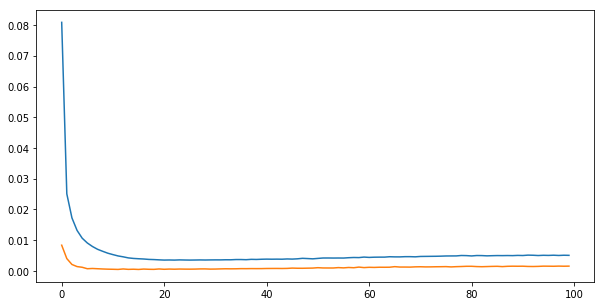

In [41]:
plt.figure(figsize=(10,5))
plt.plot(train_state['train_loss'], label='train loss')
plt.plot(train_state['val_loss'], label='val loss')

In [42]:
test_df=dataset.test_df
print(test_df.columns.get_loc('XLF'))
print(test_df.columns.get_loc('XLK'))

3
5


In [43]:
model.load_state_dict(torch.load(args.model_state_file))
model.eval()

TimeSeriesGPT(
  (target_fc): Linear(in_features=2, out_features=48, bias=True)
  (target_pos): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (stacked_decoders): ModuleList(
    (0): Decoder(
      (attn_masked): MultiHeadAttention(
        (attn_heads): ModuleList(
          (0): ScaleDotProductAttention(
            (query_fc): Linear(in_features=48, out_features=16, bias=True)
            (key_fc): Linear(in_features=48, out_features=16, bias=True)
            (value_fc): Linear(in_features=48, out_features=16, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): ScaleDotProductAttention(
            (query_fc): Linear(in_features=48, out_features=16, bias=True)
            (key_fc): Linear(in_features=48, out_features=16, bias=True)
            (value_fc): Linear(in_features=48, out_features=16, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (2): ScaleDotProductAttention(
         

In [44]:
lossfun = torch.nn.MSELoss()

In [45]:
x_input = np.array(test_df.iloc[60:-args.sequence_length, [3, 5]]).astype(np.float32)
y_pred = np.zeros(x_input.shape)
y_pred[:args.sequence_length] = np.nan
y_pred2 = np.zeros(x_input.shape)
y_pred2[-args.sequence_length:] = np.nan
for i in range(len(x_input) - args.sequence_length):
    #target_input = torch.tensor(x_input[i:i+args.sequence_length]).unsqueeze(1).unsqueeze(0).to(torch.device("cuda"))
    target_input = torch.tensor(x_input[i:i+args.sequence_length]).unsqueeze(0).to(torch.device("cuda"))
    x_out = model(sequence=target_input,
                  teacher_forcing_prob_threshold=0.0)
    #print(lossfun(x_out, target_input[:, 1:, :]))
    #print(x_input[i+args.sequence_length], x_out.squeeze().detach().cpu().numpy()[-1])
    y_pred[i+args.sequence_length] = x_out.squeeze().detach().cpu().numpy()[-1]
    y_pred2[i] = x_out.squeeze().detach().cpu().numpy()[-1]

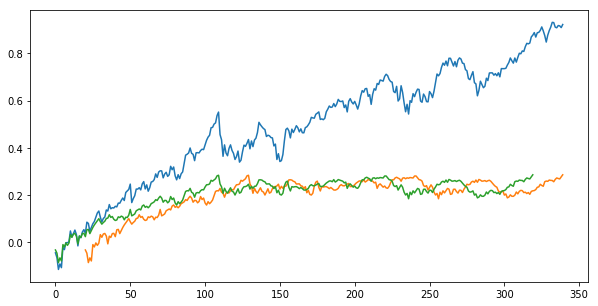

In [46]:
plt.figure(figsize=(10,5))
plt.plot(x_input[:,1], label='x_input')
plt.plot(y_pred[:,1], label='y_pred')
plt.plot(y_pred2[:,1], label='y_pred2')

In [47]:
x_input_train = np.array(dataset.train_df.iloc[-250:, [3,5]]).astype(np.float32)
y_pred_train = np.zeros(x_input_train.shape)
y_pred_train[:args.sequence_length] = np.nan
y_pred2_train = np.zeros(x_input_train.shape)
y_pred2_train[-args.sequence_length:] = np.nan
for i in range(len(x_input_train) - args.sequence_length):
    target_input_train = torch.tensor(x_input_train[i:i+args.sequence_length]).unsqueeze(0).to(torch.device("cuda"))
    x_out = model(sequence=target_input_train,
                  teacher_forcing_prob_threshold=0.0)
    #print(lossfun(x_out, target_input[:, 1:, :]))
    #print(x_input[i+args.sequence_length], x_out.squeeze().detach().cpu().numpy()[-1])
    y_pred_train[i+args.sequence_length] = x_out.squeeze().detach().cpu().numpy()[0]
    y_pred2_train[i] = x_out.squeeze().detach().cpu().numpy()[-1]

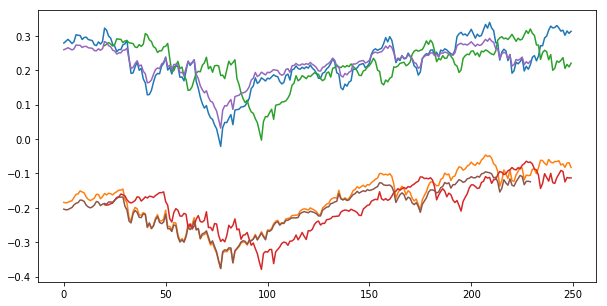

In [48]:
plt.figure(figsize=(10,5))
plt.plot(x_input_train, label='x_input')
plt.plot(y_pred_train, label='y_pred')
plt.plot(y_pred2_train, label='y_pred2')

In [12]:
args = Namespace(dataset_csv="sector_etf_logchg.csv",
                 model_state_file="transform_ts_model.pth",
                 save_dir="model_storage/stock/",
                 reload_from_files=True,
                 expand_filepaths_to_save_dir=True,
                 cuda=True,
                 seed=1337,
                 learning_rate=1e-4,
                 batch_size=64,
                 num_epochs=20,
                 num_encoder_layer=5,
                 num_decoder_layer=5,
                 num_attn_heads=3,
                 model_size=48,
                 dropout=0.1,
                 early_stopping_criteria=100,
                 sequence_length=30,
                 lookback_window=20,
                 forward_window=20,
                 catch_keyboard_interrupt=True)